In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Политех/питон_проект/Data_Model_Pizza_Sales.xlsx')

In [ ]:
df.head(3)

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza


## Агрегирование данных

In [ ]:
#общая сумма выручки за все дни
df.total_price.sum()

817860.05

In [ ]:
#группировка данных по дате заказа
new_df = df.groupby(by=['order_date'],as_index=False)[['total_price']].sum().sort_values(by='order_date', ascending=True)

# new_df = df.groupby(by=['order_date'],as_index=False)[['quantity']].sum().sort_values(by='order_date', ascending=True)
# new_df["quantity"] = df_quantity["quantity"]

In [ ]:
new_df.shape

(358, 2)

In [ ]:
new_df.head(3)

,order_date,total_price
0,2015-01-01,2713.85
1,2015-01-02,2731.90
2,2015-01-03,2662.40


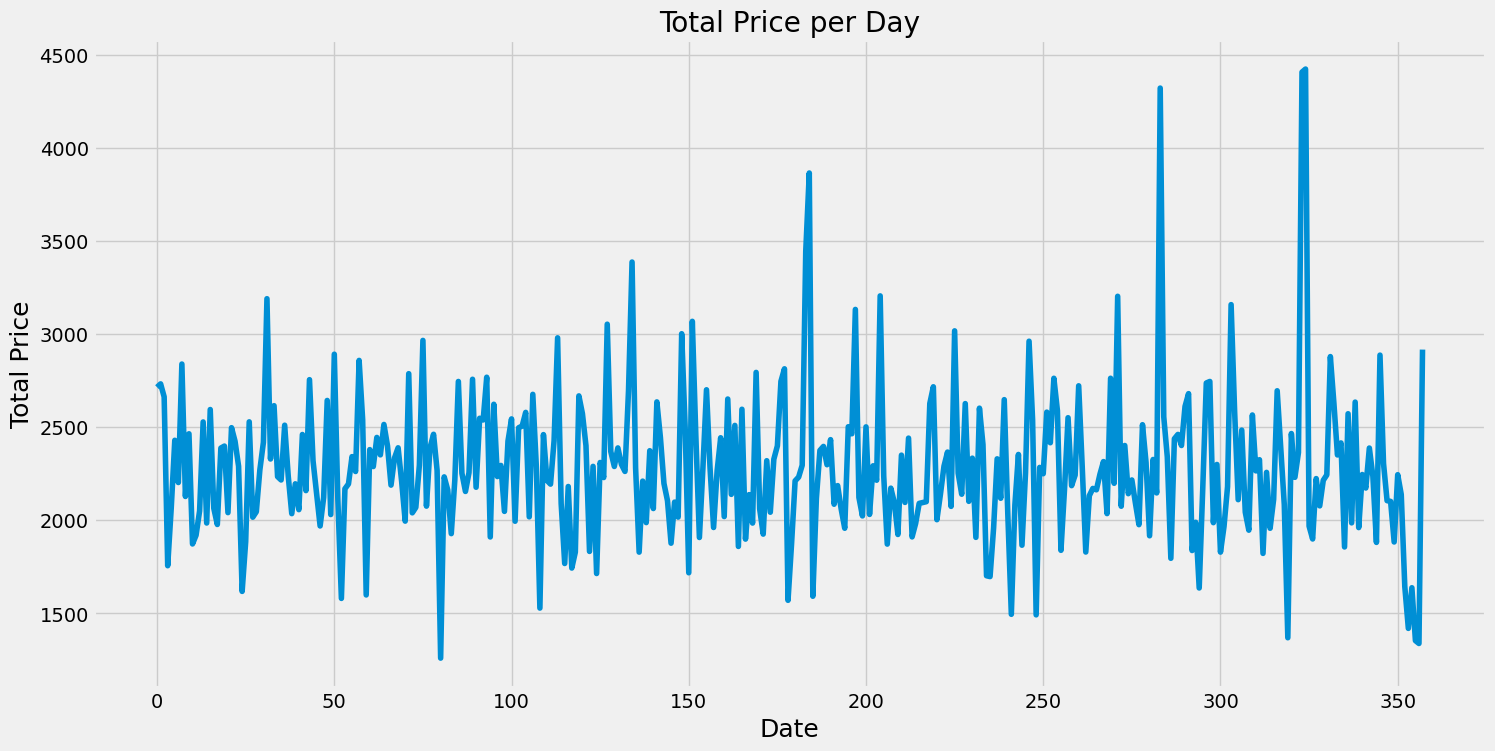

In [ ]:
#график с выручкой в день
plt.figure(figsize=(16,8))
plt.title('Total Price per Day')
plt.plot(new_df['total_price'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Total Price',fontsize=18)
plt.show()

## MinMaxScaler

In [ ]:
data = new_df.filter(['total_price'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

#масштабирование данных
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#обучающий набор данных

train_data = scaled_data[0:training_data_len,:]

#split the data into x_train and y_train data sets

x_train =[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:

    print(x_train)
    print(y_train)
    print()

[array([0.45985078, 0.46555703, 0.44358561, 0.15686646, 0.25502656,
       0.36978376, 0.29810003, 0.49920966, 0.27443728, 0.38084851,
       0.1938069 , 0.20858624, 0.24985774, 0.40090731, 0.22937215,
       0.42200936, 0.2544417 , 0.22685888, 0.3565693 , 0.35996775,
       0.24699671, 0.39120195, 0.36812405, 0.32561963, 0.11327137,
       0.19763214, 0.4011128 , 0.23923558, 0.24849836, 0.31962886,
       0.36627466, 0.61012582, 0.33805956, 0.42853756, 0.30812152,
       0.30239947, 0.39539074, 0.30930703, 0.24524216, 0.2959345 ,
       0.25203907, 0.37959977, 0.28437974, 0.47270169, 0.33507208,
       0.27883156, 0.22431399, 0.27271434, 0.43740516, 0.24374052,
       0.51590162, 0.26926846, 0.10138467, 0.28746206, 0.29568159,
       0.34207448, 0.31678364, 0.50540592, 0.40476416, 0.1072648 ])]
[0.3540085988872029]



In [ ]:
#преобразовать обучающие данные в массив numpy
x_train,y_train = np.array(x_train),np.array(y_train)

#Reshape
x_train.shape

(227, 60)

In [ ]:
# Модель сети LSTM расшифровывается как сети с долговременной краткосрочной памятью (Long Short Term Memory). 
#Это особый вид нейронных сетей, которые обычно способны различать долгосрочные зависимости. 
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#компиляция модели
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
#обучение модели
model.fit(x_train,y_train,batch_size=1,epochs=1)

227/227 [==============================] - 12s 32ms/step - loss: 0.0180


In [ ]:
#набор тестовых данных
#новый массив, содержащий сотавшиеся значение
test_data = scaled_data[training_data_len - 60:,:]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
#преобразовать обучающие данные в массив numpy
x_test = np.array(x_test)
#reshape
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
#предсказание стоимости
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 16ms/step


In [ ]:
#Get the root mean squared error(RMSE)
rmse=np.sqrt( np.mean((predictions - y_test)**2))
rmse

526.9877191247598

<ipython-input-83-eb5dbc75e766>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


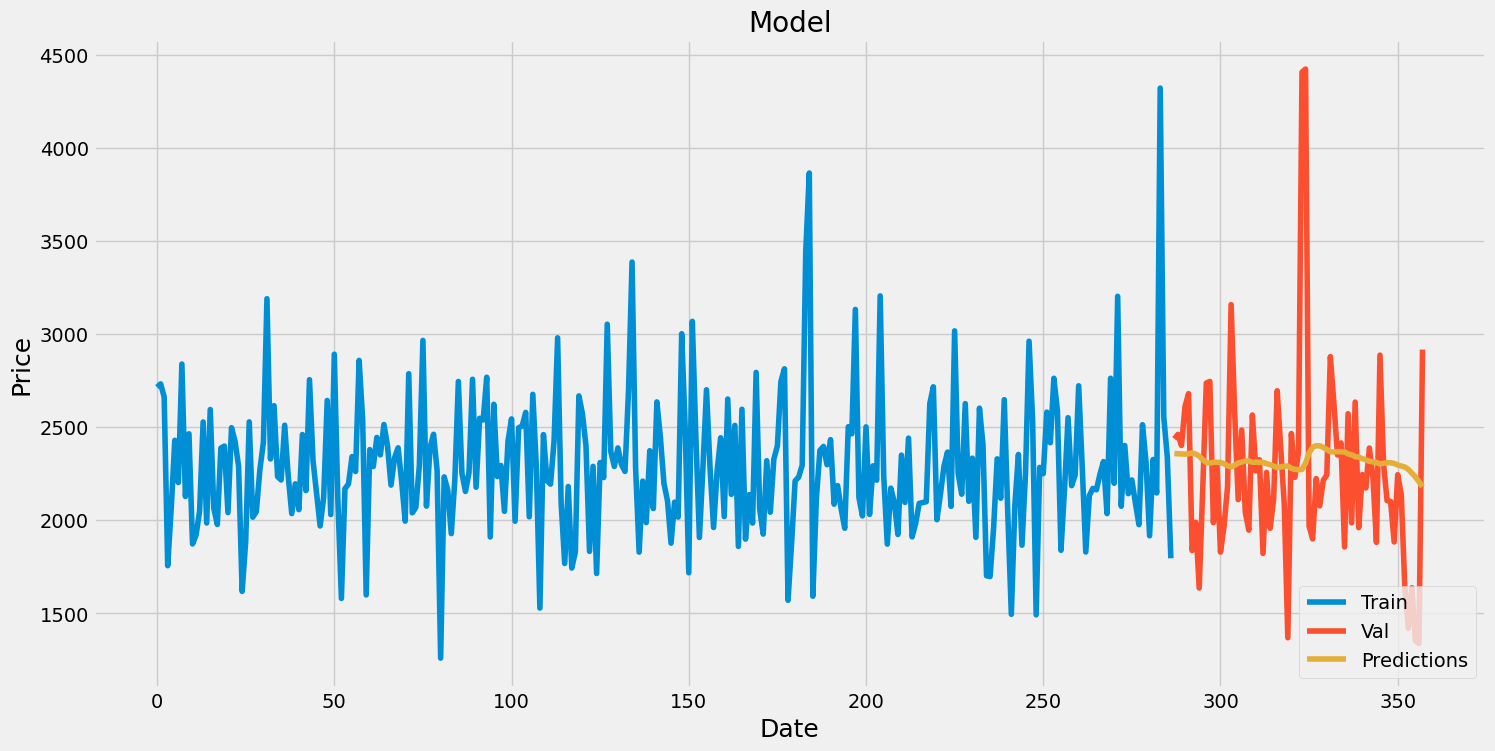

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.plot(train['total_price'])
plt.plot(valid[['total_price','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

## Prophet

In [ ]:
# import io, os, sys, setuptools, tokenize
!pip install prophet

In [ ]:
import prophet as Prophet

In [ ]:
data = new_df.rename(columns={"order_date":"ds","total_price":"y"})

In [ ]:
model = Prophet.Prophet()
model.fit(data)
predict=model.make_future_dataframe(periods=365)
forcast=model.predict(predict)

forcast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsr5y09fq/d2fnjwdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsr5y09fq/c9xw55qp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11291', 'data', 'file=/tmp/tmpsr5y09fq/d2fnjwdv.json', 'init=/tmp/tmpsr5y09fq/c9xw55qp.json', 'output', 'file=/tmp/tmpsr5y09fq/prophet_modelt9cj5tu4/prophet_model-20230516181310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
718,2016-12-26,2213.264611,1777.443585,2645.090195
719,2016-12-27,2172.394039,1753.817107,2591.773402
720,2016-12-28,2177.654981,1733.576679,2580.836494
721,2016-12-29,2352.759939,1879.135842,2772.807287
722,2016-12-30,2698.340089,2265.848911,3137.875894


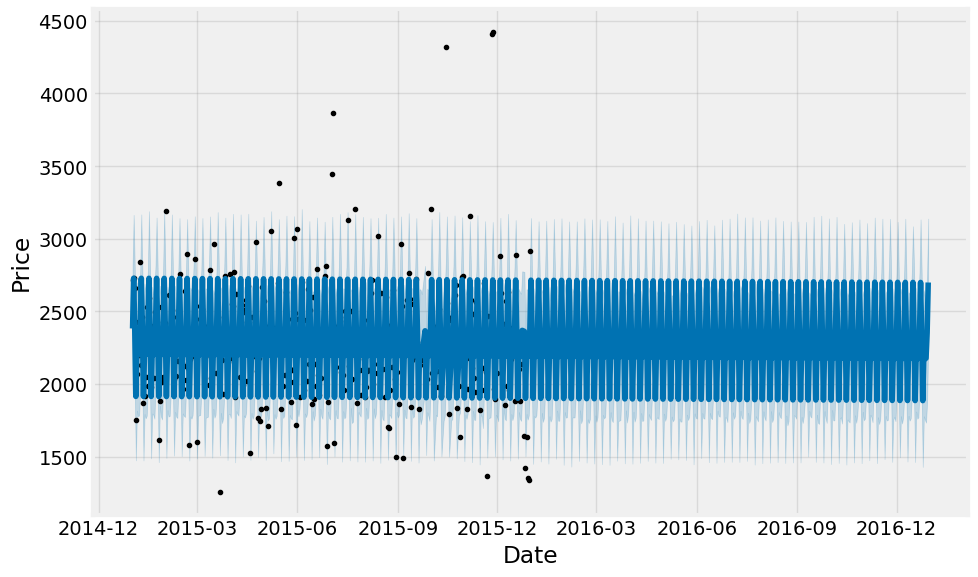

In [ ]:
graph = model.plot(forcast, xlabel="Date", ylabel="Price")

## Statistics

In [ ]:
names = pd.DataFrame(df['pizza_name'].value_counts())

In [ ]:
names.head(5)

,pizza_name
The Classic Deluxe Pizza,2416
The Barbecue Chicken Pizza,2372
The Hawaiian Pizza,2370
The Pepperoni Pizza,2369
The Thai Chicken Pizza,2315


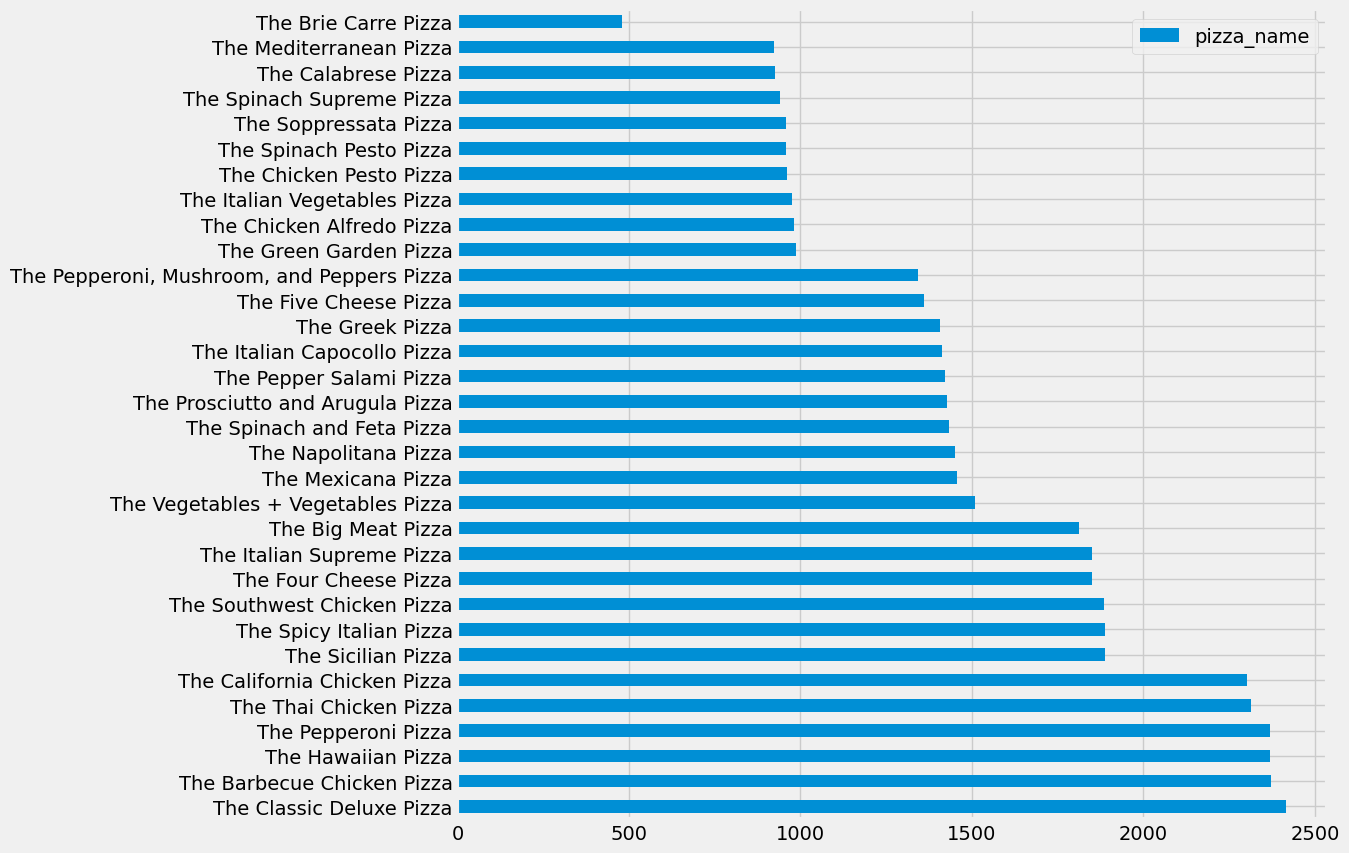

In [ ]:
plot = names.plot.barh(y='pizza_name', figsize=(10, 10))

In [ ]:
top_pizzas = names[:5] 

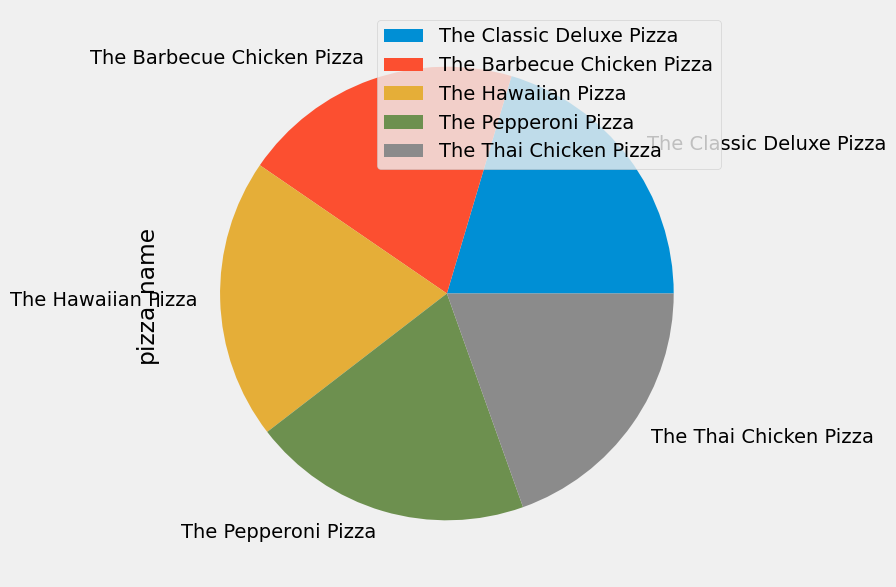

In [ ]:
plot = top_pizzas.plot.pie(y='pizza_name', figsize=(7, 7))